# Downloading & Exploring Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
import seaborn as sns

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)

import cv2
import torch
import torch.optim
from albumentations.pytorch import ToTensorV2
from torch import nn

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("titan15555/uavid-semantic-segmentation-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.69G/3.69G [00:51<00:00, 76.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/titan15555/uavid-semantic-segmentation-dataset/versions/1


In [ ]:
!ls $path

test  train  valid


In [ ]:
!ls $path/train/train

seq1   seq11  seq13  seq15  seq3   seq32  seq34  seq4  seq6  seq8
seq10  seq12  seq14  seq2   seq31  seq33  seq35  seq5  seq7  seq9


In [ ]:
!ls $path/train/train/seq1

Images	Labels


In [ ]:
!ls $path/train/train/seq1/Images

000000.png  000200.png	000400.png  000600.png	000800.png
000100.png  000300.png	000500.png  000700.png	000900.png


In [3]:
train_dir = os.path.join(path, 'train', 'train')
test_dir = os.path.join(path, 'test', 'test')
val_dir = os.path.join(path, 'valid', 'valid')

print(len(os.listdir(train_dir)), len(os.listdir(test_dir)), len(os.listdir(val_dir)))

20 1 7


# EDA & Data Distributions

In [ ]:
# The number of whole images in each subset

not_image_files = []
for subset in [train_dir, test_dir, val_dir]:
    print(f'Exploring {subset}:')
    samples = dict()
    for seq in os.listdir(subset):
        seq_dir_images = os.path.join(subset, seq, 'Images')
        samples[seq] = []
        for files in os.listdir(seq_dir_images):
            if files.endswith('.jpg') or files.endswith('.png'):
                samples[seq].append(files)
            else:
                not_image_files.append(files)
    print(f'Number of sequences: {len(samples.keys())}')
    count = 0
    for seq_len in [len(samples[seq]) for seq in samples.keys()]:
        count+=seq_len
    print(f'Number of images: {count}')
    print([len(samples[seq]) for seq in samples.keys()])
    print('-----------------------------------------------------')

Exploring /root/.cache/kagglehub/datasets/titan15555/uavid-semantic-segmentation-dataset/versions/1/train/train:
Number of sequences: 20
Number of images: 200
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
-----------------------------------------------------
Exploring /root/.cache/kagglehub/datasets/titan15555/uavid-semantic-segmentation-dataset/versions/1/test/test:
Number of sequences: 1
Number of images: 10
[10]
-----------------------------------------------------
Exploring /root/.cache/kagglehub/datasets/titan15555/uavid-semantic-segmentation-dataset/versions/1/valid/valid:
Number of sequences: 7
Number of images: 70
[10, 10, 10, 10, 10, 10, 10]
-----------------------------------------------------


In [ ]:
len(not_image_files)

0

In [ ]:
# Exploring labels

not_label_files = []
for subset in [train_dir, val_dir]:
    print(f'Exploring {subset}:')
    samples = dict()
    unique_labels = set() # Initialize as a set to collect unique values efficiently
    shapes = set()
    for seq in os.listdir(subset):
        seq_dir_labels = os.path.join(subset, seq, 'Labels')
        samples[seq] = []
        for files in os.listdir(seq_dir_labels):
            if files.endswith('.jpg') or files.endswith('.png'):
                label_path = os.path.join(seq_dir_labels, files)
                samples[seq].append(label_path)
                label = PIL.Image.open(label_path)
                label_array = np.array(label)
                shapes.add(label_array.shape)
                unique_labels.update(np.unique(label_array)) # Use update to add unique elements to the set
            else:
                not_label_files.append(files)
    print(f'Number of sequences: {len(samples.keys())}')
    count = 0
    for seq_len in [len(samples[seq]) for seq in samples.keys()]:
        count+=seq_len
    print(f'Number of labels: {count}')
    print([len(samples[seq]) for seq in samples.keys()])
    print(f'Unique labels: {np.sort(list(unique_labels))}') # Convert set to a sorted list for printing
    print(f'Unique shapes: {shapes}')
    print('-----------------------------------------------------')

Exploring /root/.cache/kagglehub/datasets/titan15555/uavid-semantic-segmentation-dataset/versions/1/train/train:
Number of sequences: 20
Number of labels: 200
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Unique labels: [  0  64 128 192]
Unique shapes: {(2160, 3840, 3), (2160, 4096, 3)}
-----------------------------------------------------
Exploring /root/.cache/kagglehub/datasets/titan15555/uavid-semantic-segmentation-dataset/versions/1/valid/valid:
Number of sequences: 7
Number of labels: 70
[10, 10, 10, 10, 10, 10, 10]
Unique labels: [  0  64 128 192]
Unique shapes: {(2160, 3840, 3), (2160, 4096, 3)}
-----------------------------------------------------


In [ ]:
np.unique(label_array)

array([  0,  64, 128, 192], dtype=uint8)

In [ ]:
label_array.shape

(2160, 3840, 3)

In [ ]:
label_array

array([[[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [128,  64, 128],
        [128,  64, 128],
        [128,  64, 128]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [128,  64, 128],
        [128,  64, 128],
        [128,  64, 128]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [128,  64, 128],
        [128,  64, 128],
        [128,  64, 128]]

000000.png


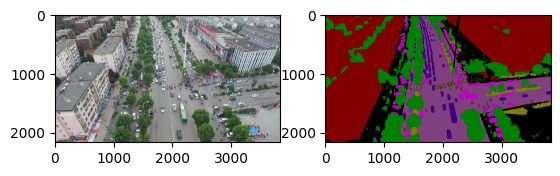

Unique labels: [  0  64 128 192]
********************
000100.png


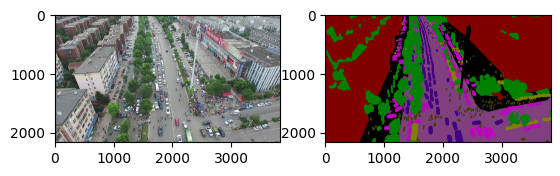

Unique labels: [  0  64 128 192]
********************
000800.png


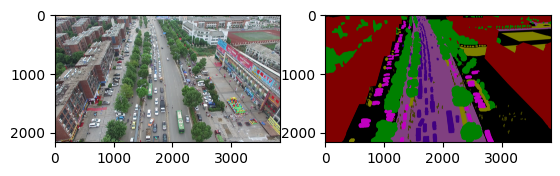

Unique labels: [  0  64 128 192]
********************
000900.png


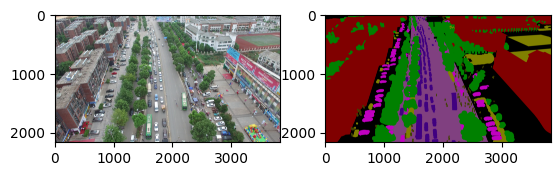

Unique labels: [  0  64 128 192]
********************
000500.png


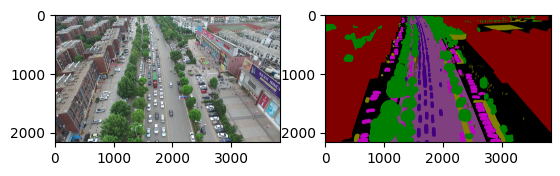

Unique labels: [  0  64 128 192]
********************
000100.png


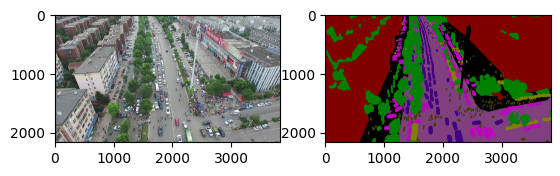

Unique labels: [  0  64 128 192]
********************
000800.png


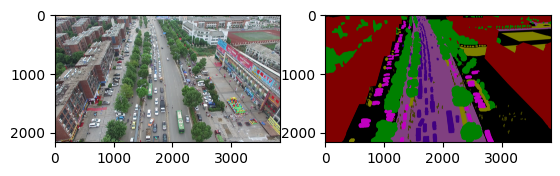

Unique labels: [  0  64 128 192]
********************
000800.png


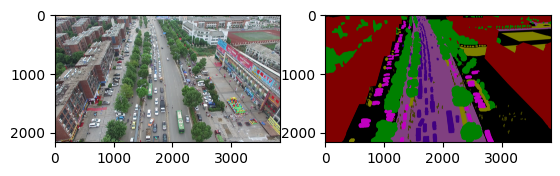

Unique labels: [  0  64 128 192]
********************
000500.png


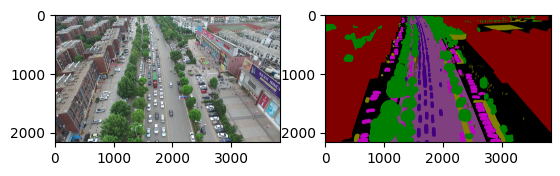

Unique labels: [  0  64 128 192]
********************
000700.png


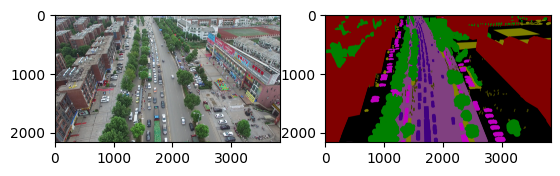

Unique labels: [  0  64 128 192]
********************


In [ ]:
# Visualize some samples
import random

val_labels = [el for key in samples.keys() for el in samples[key]]

sample = random.sample(val_labels, 10)

for label_path in sample:
    print(label_path.split('/')[-1])
    label = PIL.Image.open(label_path)
    label_array = np.array(label)

    img_path = label_path.replace('Labels', 'Images')
    img = PIL.Image.open(img_path)

    plt.subplot(121)
    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(label)
    plt.show()
    print(f'Unique labels: {np.unique(label_array)}')
    print(20*'*')


In [ ]:
unique_colors = np.unique(label_array.reshape(-1, label_array.shape[2]), axis=0)
print(f"Number of unique colors: {len(unique_colors)}")
print(f"Unique colors:\n{unique_colors}")

Number of unique colors: 8
Unique colors:
[[  0   0   0]
 [  0 128   0]
 [ 64   0 128]
 [ 64  64   0]
 [128   0   0]
 [128  64 128]
 [128 128   0]
 [192   0 192]]


**Explanation:** <br>
* label_array: This is your original NumPy array representing the image (or label mask). For a color image, its shape is typically (height, width, 3), where 3 corresponds to the Red, Green, and Blue color channels.

* label_array.shape[2]: This part simply retrieves the size of the third dimension of your label_array. In our case, for an RGB image, this will be 3 (representing the R, G, and B components of each pixel).

* label_array.reshape(-1, label_array.shape[2]): This is a crucial step.

  1.  reshape() is a NumPy function that changes the dimensions (shape) of an array without changing its data.

  2. We use -1 in the first dimension argument. When you use -1, NumPy automatically calculates the size of that dimension based on the total number of elements in the array and the size of the other specified dimensions. In this case, it effectively flattens the height and width dimensions into a single dimension.

  3. The second dimension argument is label_array.shape[2], which we determined to be 3. This means we are reshaping the array into a 2D array where each 'row' has 3 columns. Each of these 'rows' now represents a single pixel's RGB color triplet [R, G, B].

  4. Example: If your label_array was (2160, 3840, 3), reshaping it with (-1, 3) turns it into an array of shape (2160 * 3840, 3). So, you get a long list of individual pixels, each represented by its [R, G, B] values.

* np.unique(..., axis=0): Finally, we apply np.unique() to this reshaped array.

  1. By default, np.unique() would find all unique scalar values in the entire array (e.g., it would return [0, 64, 128, 192] as unique individual numbers, not unique color combinations).
  2. However, by adding axis=0, we tell np.unique() to look for unique rows. Since each row in our reshaped array is an [R, G, B] color triplet, np.unique(..., axis=0) effectively finds all the unique [R, G, B] color combinations present in your image.

# Preprocessing Labels: RGB to Class ID Mask

To prepare the labels for a semantic segmentation model, we need to convert the 3-channel RGB images into single-channel masks where each pixel's value is an integer representing its class. We will use the `unique_colors` identified previously to create a mapping.

## Gemini Version

In [ ]:
# Assuming 'unique_colors' is available from the previous execution
# If not, it can be re-run or defined manually based on the output:
# unique_colors = np.array(
#     [[  0,   0,   0],
#      [  0, 128,   0],
#      [ 64,   0, 128],
#      [ 64  64   0],
#      [128   0   0],
#      [128  64 128],
#      [128 128   0],
#      [192   0 192]], dtype=np.uint8)

# Create a mapping from RGB tuple to class ID
color_to_class_map = {tuple(color): i for i, color in enumerate(unique_colors)}

print("RGB to Class ID Map:")
for color, class_id in color_to_class_map.items():
    print(f"  {color} -> {class_id}")

RGB to Class ID Map:
  (np.uint8(0), np.uint8(0), np.uint8(0)) -> 0
  (np.uint8(0), np.uint8(128), np.uint8(0)) -> 1
  (np.uint8(64), np.uint8(0), np.uint8(128)) -> 2
  (np.uint8(64), np.uint8(64), np.uint8(0)) -> 3
  (np.uint8(128), np.uint8(0), np.uint8(0)) -> 4
  (np.uint8(128), np.uint8(64), np.uint8(128)) -> 5
  (np.uint8(128), np.uint8(128), np.uint8(0)) -> 6
  (np.uint8(192), np.uint8(0), np.uint8(192)) -> 7


Original label_array shape: (2160, 3840, 3)
Converted mask shape: (2160, 3840)
Unique class IDs in the example mask: [0 1 2 3 4 5 6 7]


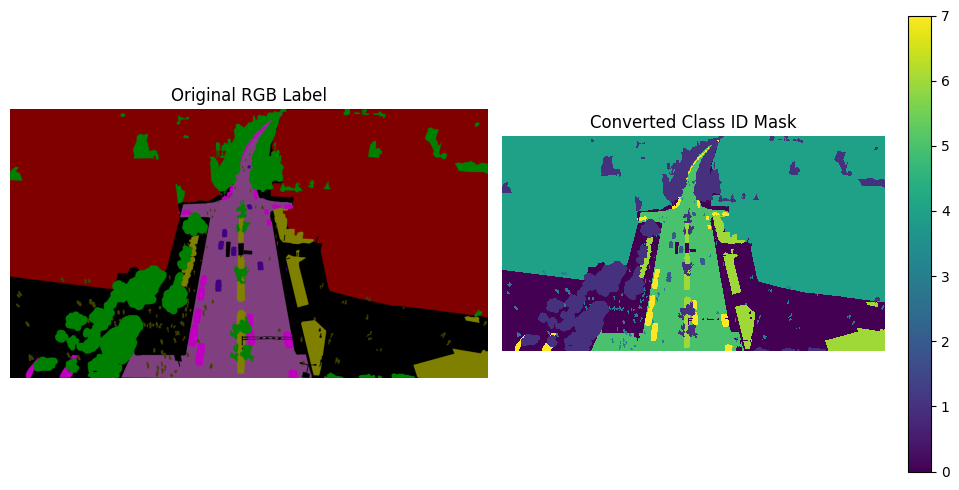

In [ ]:
def rgb_to_mask(rgb_label_image, color_map):
    """
    Converts a 3-channel RGB label image to a single-channel class ID mask.

    Args:
        rgb_label_image (np.ndarray): The 3-channel (H, W, 3) RGB label image.
        color_map (dict): A dictionary mapping (R, G, B) tuples to class IDs.

    Returns:
        np.ndarray: A single-channel (H, W) mask with integer class IDs.
    """
    height, width, _ = rgb_label_image.shape
    mask = np.zeros((height, width), dtype=np.uint8) # Use np.uint8 for class IDs

    # Reshape the RGB image to a list of pixels for easier lookup
    # and convert to tuples for dictionary key compatibility
    rgb_pixels_tuples = [tuple(p) for p in rgb_label_image.reshape(-1, 3)]

    # Map each RGB tuple to its corresponding class ID
    # Default to 0 (background) if a color is not found in the map
    class_ids = [color_map.get(rgb_tuple, 0) for rgb_tuple in rgb_pixels_tuples]

    # Reshape back to the original image dimensions
    mask = np.array(class_ids, dtype=np.uint8).reshape(height, width)

    return mask

# Demonstrate with the last 'label_array' from the previous exploration
print(f"Original label_array shape: {label_array.shape}")
example_mask = rgb_to_mask(label_array, color_to_class_map)
print(f"Converted mask shape: {example_mask.shape}")
print(f"Unique class IDs in the example mask: {np.unique(example_mask)}")

# Display the original RGB label and the converted mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original RGB Label")
plt.imshow(label_array)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Converted Class ID Mask")
# When displaying a mask, use a 'nearest' interpolation for clear class boundaries
# and a colormap that highlights distinct classes.
plt.imshow(example_mask, cmap='viridis', interpolation='nearest')
plt.colorbar(ticks=np.unique(example_mask))
plt.axis('off')

plt.tight_layout()
plt.show()

After this conversion, your `example_mask` is a single-channel image where each pixel contains an integer from 0 to 7 (or however many unique classes you have). This is the standard format for semantic segmentation labels.

Other common preprocessing steps for semantic segmentation often include:

*   **Resizing/Cropping**: Adjusting image dimensions to a fixed size required by your model.
*   **Normalization**: Scaling pixel values (for both input images and masks if needed for specific models) to a common range (e.g., 0-1 or -1 to 1).
*   **Data Augmentation**: Applying random transformations (rotation, flip, zoom) to both images and their corresponding masks to increase dataset size and improve model generalization.

## My own version :)

In [ ]:
import random

val_labels = [el for key in samples.keys() for el in samples[key]]

sample = random.sample(val_labels, 10)

In [ ]:
unique_colors = np.unique(label_array.reshape(-1, label_array.shape[2]), axis=0)
unique_colors

array([[  0,   0,   0],
       [  0, 128,   0],
       [ 64,   0, 128],
       [ 64,  64,   0],
       [128,   0,   0],
       [128,  64, 128],
       [128, 128,   0],
       [192,   0, 192]], dtype=uint8)

In [ ]:
unique_colors.shape

(8, 3)

In [ ]:
color_map = {tuple(color): i for i, color in enumerate(unique_colors)}
color_map


{(np.uint8(0), np.uint8(0), np.uint8(0)): 0,
 (np.uint8(0), np.uint8(128), np.uint8(0)): 1,
 (np.uint8(64), np.uint8(0), np.uint8(128)): 2,
 (np.uint8(64), np.uint8(64), np.uint8(0)): 3,
 (np.uint8(128), np.uint8(0), np.uint8(0)): 4,
 (np.uint8(128), np.uint8(64), np.uint8(128)): 5,
 (np.uint8(128), np.uint8(128), np.uint8(0)): 6,
 (np.uint8(192), np.uint8(0), np.uint8(192)): 7}

In [ ]:
label_array.shape[0], label_array.shape[1]

(2160, 3840)

In [ ]:
rgb_pixels_tuples = [tuple(p) for p in label_array.reshape(-1, 3)]
gray_pixels = [color_map[rgb_pixels_tuples[i]] for i in range(len(rgb_pixels_tuples))]
gray_pixels = np.array(gray_pixels, dtype=np.uint8).reshape(label_array.shape[0], label_array.shape[1])
gray_pixels.shape, np.unique(gray_pixels)

((2160, 3840), array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8))

## Data Preparation

torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

__len__ so that len(dataset) returns the size of the dataset.

__getitem__ to support the indexing such that dataset[i] can be used to get
ith sample.

In [4]:
def create_data_paths(data_dir):
    data_paths = []
    for seq in os.listdir(data_dir):
        seq_dir_images = os.path.join(data_dir, seq, 'Images')
        for files in os.listdir(seq_dir_images):
            if files.endswith('.jpg') or files.endswith('.png'):
                file_path = os.path.join(seq_dir_images, files)
                data_paths.append(file_path)
    return data_paths


train_paths = create_data_paths(train_dir)
val_paths = create_data_paths(val_dir)
test_paths = create_data_paths(test_dir)

print(len(train_paths), len(val_paths), len(test_paths))

200 70 10


In [5]:
# color_map (dict): A dictionary mapping (R, G, B) tuples to class IDs.
# Background clutter (0,0,0)
# Building (128,0,0)
# Road (128,64,128)
# Tree (0,128,0)
# Low vegetation (128,128,0)
# Moving car (64,0,128)
# Static car (192,0,192)
# Human (64,64,0)

color_map = {(np.uint8(0), np.uint8(0), np.uint8(0)): 0,  # Background
            (np.uint8(0), np.uint8(128), np.uint8(0)): 1,  # Tree
            (np.uint8(64), np.uint8(0), np.uint8(128)): 2,  # Moving car
            (np.uint8(64), np.uint8(64), np.uint8(0)): 3,  # Human
            (np.uint8(128), np.uint8(0), np.uint8(0)): 4,  # Building
            (np.uint8(128), np.uint8(64), np.uint8(128)): 5,  # Road
            (np.uint8(128), np.uint8(128), np.uint8(0)): 6,  # Low vegetation
            (np.uint8(192), np.uint8(0), np.uint8(192)): 7}  # Static car

def rgb_to_mask(rgb_label_array):
    """
    Converts a 3-channel RGB label image to a single-channel class ID mask.

    Args:
        rgb_label_image (np.ndarray): The 3-channel (H, W, 3) RGB label image.

    Returns:
        np.ndarray: A single-channel (H, W) mask with integer class IDs.
    """
    rgb_pixels_tuples = [tuple(p) for p in rgb_label_array.reshape(-1, 3)]
    gray_mask = [color_map[rgb_pixels_tuples[i]] for i in range(len(rgb_pixels_tuples))]
    gray_mask = np.array(gray_mask, dtype=np.uint8).reshape(rgb_label_array.shape[0],
                                                                rgb_label_array.shape[1])
    return gray_mask

**Note about using to_categorical in this context:** <br>
the answer depends on the deep learning framework you're using and the specific loss function your model will employ.

**For PyTorch (Common Approach): No, you typically do NOT use to_categorical**
In PyTorch, for multi-class semantic segmentation, the most common approach is to use torch.nn.CrossEntropyLoss as your loss function. This loss function expects the target (your mask) to be integer class IDs (i.e., your single-channel (H, W) mask with pixel values from 0 to 7) and not one-hot encoded.

The model's output layer, in this case, would typically produce N channels (where N is the number of classes), representing the raw logits for each class at every pixel location. The CrossEntropyLoss function then internally applies a softmax to these logits and computes the loss against your integer-encoded target mask.

Example Flow with PyTorch's CrossEntropyLoss:

1. Input Image: (C, H, W) (e.g., (3, 256, 256))
2. Model Output (logits): (N_classes, H, W) (e.g., (7, 256, 256) where 7 is your number of classes)
3. Target Mask (your gray_mask): (H, W) with integer class IDs (e.g., (256, 256) with pixel values 0-6)
4. Loss Calculation: loss = torch.nn.CrossEntropyLoss()(model_output_logits, target_mask.long())
Therefore, your gray_mask (with integer class IDs) is in the perfect format for torch.nn.CrossEntropyLoss.

**When to_categorical (One-Hot Encoding) MIGHT be needed:**
* **Custom Loss Functions:** If you were implementing a custom loss function that explicitly requires one-hot encoded labels (e.g., some variations of Dice Loss or Focal Loss might expect this, though many have versions that can handle integer masks).
* **Keras/TensorFlow (if using CategoricalCrossentropy):** In TensorFlow/Keras, if you use tf.keras.losses.CategoricalCrossentropy, you would need to one-hot encode your labels. However, if you use tf.keras.losses.SparseCategoricalCrossentropy, you would not need to, as it expects integer class IDs, similar to PyTorch's CrossEntropyLoss.

**Why avoiding to_categorical is often better:**
* Memory Efficiency: One-hot encoding significantly increases the memory footprint of your labels. A (H, W) mask becomes an (N_classes, H, W) tensor. For large images and many classes, this can consume a lot of GPU memory.
* Computational Efficiency: It adds an extra computational step that CrossEntropyLoss handles internally more efficiently.
So, based on the standard practices for semantic segmentation in PyTorch, stick with your single-channel integer masks!

So, what about the ordinal relation between 0 - 7 labels?

Indeed, when we represent our 7 classes as integer IDs from 0 to 6 (or 0 to 7 as you have), those numbers are inherently ordinal. If these numbers were used in a context where their numerical value implies a relationship (e.g., if class 6 was 'twice as important' or 'further away' from class 0 than class 1), that would be a significant problem.

However, in the context of semantic segmentation with a loss function like PyTorch's CrossEntropyLoss (or TensorFlow's SparseCategoricalCrossentropy), these integer labels (0, 1, 2, ..., 7) are not treated as ordinal values with meaningful magnitudes by the loss function itself. Instead, they are interpreted purely as indices or identifiers for the classes.

Let me explain how this works to alleviate the concern about false ordinal relationships:

1. Model Output: Your segmentation model typically outputs a tensor of shape (N_classes, H, W) (e.g., (8, 2160, 3840) for 8 classes). For each pixel, this tensor contains 8 values (logits). Each logit corresponds to the model's unnormalized prediction for one of your classes (class 0, class 1, ..., class 7).

2. Target Mask: Your gray_mask has shape (H, W) (e.g., (2160, 3840)), where each pixel's value is an integer from 0 to 7.

3. Loss Calculation (CrossEntropyLoss): When CrossEntropyLoss computes the loss for a specific pixel, it does the following:

It takes the integer value from your gray_mask (e.g., if a pixel is labeled 6).
It uses this 6 as an index to select the corresponding logit from the model's output for that pixel (i.e., the logit for class 6).
It then calculates the cross-entropy loss by comparing this selected logit (and implicitly the probabilities for all classes) against a

In [6]:
def get_transforms(phase, height, width, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(),
                ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=10, # rotate
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT
                ),
#                 GaussNoise(),
            ]
        )
    list_transforms.extend(
        [
            Resize(height, width), # Correctly pass height and width
            Normalize(mean=mean, std=std, p=1),
            ToTensorV2()
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

In [7]:
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from pathlib import Path
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


# transformer = transforms.ToTensor() # Handles numpy array -> tensor, scales to [0,1]

# Background clutter (0,0,0)
# Building (128,0,0)
# Road (128,64,128)
# Tree (0,128,0)
# Low vegetation (128,128,0)
# Moving car (64,0,128)
# Static car (192,0,192)
# Human (64,64,0)

color_map = {(np.uint8(0), np.uint8(0), np.uint8(0)): 0,  # Background
            (np.uint8(0), np.uint8(128), np.uint8(0)): 1,  # Tree
            (np.uint8(64), np.uint8(0), np.uint8(128)): 2,  # Moving car
            (np.uint8(64), np.uint8(64), np.uint8(0)): 3,  # Human
            (np.uint8(128), np.uint8(0), np.uint8(0)): 4,  # Building
            (np.uint8(128), np.uint8(64), np.uint8(128)): 5,  # Road
            (np.uint8(128), np.uint8(128), np.uint8(0)): 6,  # Low vegetation
            (np.uint8(192), np.uint8(0), np.uint8(192)): 7}  # Static car


class SemanticSegmentationDataset(Dataset):
    CLASSES = [
        "Background",
        "Tree",
        "Moving car",
        "Human",
        "Building",
        "Road",
        "Low vegetation",
        "Static car",
    ]
    def __init__(self,
                 data_paths: Path,
                 phase: str,
                 height=256,
                 width=256,
                 mean=(0.485, 0.456, 0.406),
                 std=(0.229, 0.224, 0.225)):
        self.data_paths = data_paths
        self.transforms = get_transforms(phase, height, width, mean, std)

        # self.size = size

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = self.data_paths[idx]
        image = cv2.imread(img_path)  # Loads as BGR, numpy array
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert to RGB
        image = image.astype(float)
        # tensor_image = transformer(image)

        label_path = img_path.replace('Images', 'Labels')
        if not os.path.exists(label_path):
            raise FileNotFoundError(f"Label file not found for image: {img_path}")
        bgr_label_array = cv2.imread(label_path)
        rgb_label_array = cv2.cvtColor(bgr_label_array, cv2.COLOR_BGR2RGB)
        mask = rgb_to_mask(rgb_label_array)
        mask = mask.astype(float)

        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']

        return image, mask


In [8]:
train_data = SemanticSegmentationDataset(train_paths, phase="train")
val_data = SemanticSegmentationDataset(val_paths, phase="val")
test_data = SemanticSegmentationDataset(test_paths, phase="test")

In [9]:
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=os.cpu_count())
val_dataloader = DataLoader(val_data, batch_size=8, shuffle=False, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=False, num_workers=os.cpu_count())

13


torch.Size([16, 3, 512, 512])
torch.Size([16, 512, 512])
torch.Size([3, 512, 512])
torch.float32
[0. 1. 2. 3. 4. 5. 6. 7.]


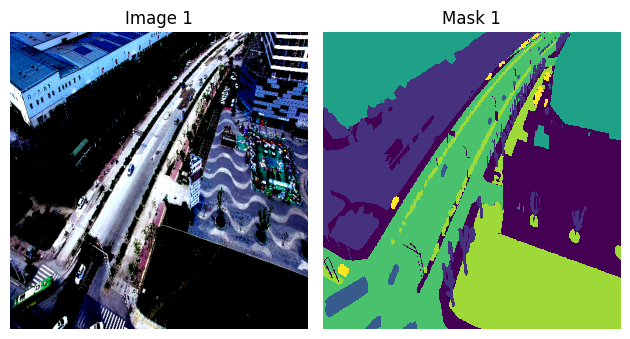

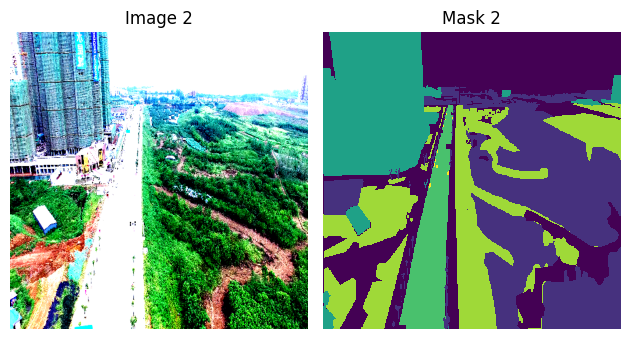

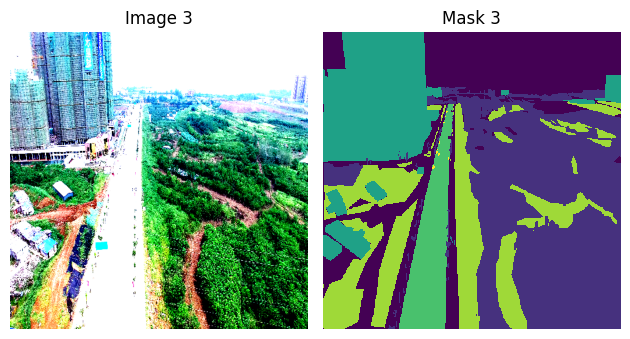

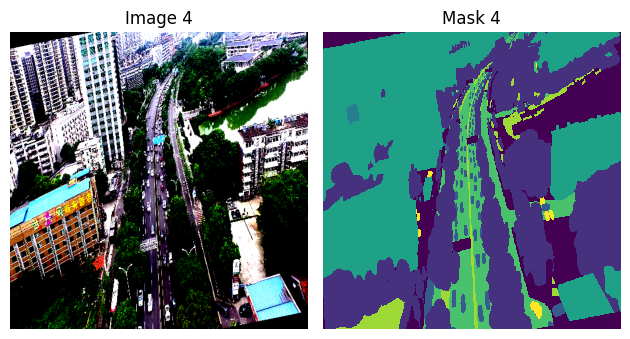

In [ ]:
# Check data loader

print(len(train_dataloader))
# Define mean and std tensors matching those used in get_transforms
# Assuming these are the values used for normalization in get_transforms
NORM_MEAN = torch.tensor([0.485, 0.456, 0.406])
NORM_STD = torch.tensor([0.229, 0.224, 0.225])

for batch in train_dataloader:
    image, mask = batch
    print(image.shape)
    print(mask.shape)
    print(image[0].shape)
    print(image[0].dtype)
    print(np.unique(mask))
    for k in range(4):
        # Process image for display
        # img_to_show = image[k].cpu() # Move to CPU if it's on GPU

        # # Denormalize the image tensor
        # # Reshape mean/std for element-wise multiplication and addition across channels
        # img_to_show = img_to_show * NORM_STD.view(3, 1, 1) + NORM_MEAN.view(3, 1, 1)

        # # Clamp values to [0, 1] as imshow expects float images in this range
        # img_to_show = torch.clamp(img_to_show, 0, 1)

        # Permute from (C, H, W) to (H, W, C) for matplotlib and convert to numpy
        img_to_show_np = image[k].permute(1, 2, 0).numpy()

        plt.subplot(121)
        plt.imshow(img_to_show_np)
        plt.title(f"Image {k+1}")
        plt.axis('off')

        # Process mask for display
        mask_to_show_np = mask[k].cpu().numpy() # Move to CPU and convert to numpy
        plt.subplot(122)
        # Use a colormap for masks to differentiate classes, and 'nearest' interpolation
        plt.imshow(mask_to_show_np, cmap='viridis', interpolation='nearest')
        plt.title(f"Mask {k+1}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    break


# Model Building

In [ ]:
# !git clone https://github.com/qubvel-org/segmentation_models.pytorch.git

In [10]:
!pip install segmentation_models_pytorch > /dev/null -q

In [11]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [12]:
# Some training hyperparameters
EPOCHS = 20
T_MAX = EPOCHS * len(train_dataloader)
# Always include the background as a class
OUT_CLASSES = len(train_data.CLASSES)

In [13]:
import segmentation_models_pytorch as smp

activation = 'sigmoid' if OUT_CLASSES == 1 else 'softmax'
model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=OUT_CLASSES,                     # model output classes (number of classes in your dataset)
    activation=activation
).to(device)


print(model)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [14]:
!pip install pytorch_lightning -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 51.9 MB/s eta 0:00:00


In [15]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch
from torch.optim import lr_scheduler


class CamVidModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(arch,
                                      encoder_name=encoder_name,
                                      in_channels=in_channels,
                                      classes=out_classes,
                                      **kwargs,
                                  ).to(device)
        # model = smp.Unet(
        #     encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        #     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        #     in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        #     classes=OUT_CLASSES,                     # model output classes (number of classes in your dataset)
        #     activation=activation
        # ).to(device)

        # Preprocessing parameters for image normalization
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.number_of_classes = out_classes
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # Loss function for multi-class segmentation
        self.loss_fn = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)

        # Step metrics tracking
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # Normalize image
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image, mask = batch

        # Ensure that image dimensions are correct
        assert image.ndim == 4  # [batch_size, channels, H, W]

        # Ensure the mask is a long (index) tensor
        mask = mask.long()

        # Mask shape
        assert mask.ndim == 3  # [batch_size, H, W]

        # Predict mask logits
        logits_mask = self.forward(image)

        assert (
            logits_mask.shape[1] == self.number_of_classes
        )  # [batch_size, number_of_classes, H, W]

        # Ensure the logits mask is contiguous
        logits_mask = logits_mask.contiguous()

        # Compute loss using multi-class Dice loss (pass original mask, not one-hot encoded)
        loss = self.loss_fn(logits_mask, mask)

        # Apply softmax to get probabilities for multi-class segmentation
        prob_mask = logits_mask.softmax(dim=1)

        # Convert probabilities to predicted class labels
        pred_mask = prob_mask.argmax(dim=1)

        # Compute true positives, false positives, false negatives, and true negatives
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask, mask, mode="multiclass", num_classes=self.number_of_classes
        )

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # Aggregate step metrics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # Per-image IoU and dataset IoU calculations
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-3)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

In [16]:
model = CamVidModel("UNet", "resnet18", encoder_weights="imagenet", in_channels=3, out_classes=OUT_CLASSES)

# Training

## camvid version

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

early_stop_callback = EarlyStopping(
    monitor='valid_dataset_iou',  # Metric to monitor
    min_delta=0.00,             # Minimum change to be considered an improvement
    patience=4,                 # How many epochs to wait before stopping if no improvement
    verbose=True,              # Don't print output
    mode='max'                  # 'max' because we want to maximize IoU
)

trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1, callbacks=[early_stop_callback])

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | Unet     | 14.3 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.317    Total estimated model params size (MB)
141       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_dataset_iou improved. New best score: 0.291


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_dataset_iou improved by 0.043 >= min_delta = 0.0. New best score: 0.334


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_dataset_iou improved by 0.030 >= min_delta = 0.0. New best score: 0.365


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_dataset_iou improved by 0.104 >= min_delta = 0.0. New best score: 0.468


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_dataset_iou improved by 0.053 >= min_delta = 0.0. New best score: 0.521


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
nvidia-smi -l 1

## my own

## Loss and Optimizer
- Loss = BCE + Dice_loss
- Optimizer = Adam with initial_lr = 1e-3
- lr_scheduler with CosineAnnealingLR for lr decay

In [ ]:
bce_loss = torch.nn.BCELoss()

def dice_loss(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return  1 - (numerator + 1) / (denominator + 1)

def bce_dice_loss(pred,target):
  return bce_loss(pred,target) + dice_loss(pred,target)

# loss_function = bce_dice_loss
# loss_function = bce_loss

# Loss function for multi-class segmentation
loss_function = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)

optimizer = torch.optim.Adam(model.parameters(), 1e-4,weight_decay=0)

epoch_num = 25
val_interval = 1

steps = epoch_num#int(len(train_slices)/batch_size)+1
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)

## Define custom metric

In [ ]:
from torch.autograd import Variable

def my_dice(y_pred,y_true,device='cpu',thr=0.5):
    thr = Variable(torch.Tensor([thr])).to(device)
    y_pred = (y_pred > thr).float() * 1
    smooth = 1e-4
    iflat = y_pred.view(-1)
    tflat = y_true.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [ ]:
def custom_metric(pred_mask, mask):

    tp, fp, fn, tn = smp.metrics.get_stats(
                pred_mask, mask, mode="multiclass", num_classes=self.number_of_classes
            )

            return {
                "loss": loss,
                "tp": tp,
                "fp": fp,
                "fn": fn,
                "tn": tn,
            }

    def shared_epoch_end(self, outputs, stage):
        # Aggregate step metrics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # Per-image IoU and dataset IoU calculations
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

## Training

In [ ]:
len(train_dataloader), len(val_dataloader)

(25, 9)

In [ ]:
# With win func andbinary masks ; lr = 1e-4; Adam; resnet18; only 50 samples; smooth = 1e-4; size = 512; Gausian noise
#
## lr = 1e-5; opt = Adam , SGD; encoders: resnet18, mobilenet_v2, densenet121; Unet++ , Unet; Without any extra transformations
import sys

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
epoch_num = 2
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_dataloader:

        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        print(f'shapes = {inputs.shape} , {labels.shape}')
        optimizer.zero_grad()
        outputs = model(inputs)
        print(f'')
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = 1+(len(train_data) // train_dataloader.batch_size)

        sys.stdout.write('\r'+f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    print('\n',f"###### epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_dataloader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            # Aggregate step metrics
            tp = torch.cat([x["tp"] for x in y_pred])
            fp = torch.cat([x["fp"] for x in y_pred])
            fn = torch.cat([x["fn"] for x in y_pred])
            tn = torch.cat([x["tn"] for x in y_pred])

            # Per-image IoU and dataset IoU calculations
            per_image_iou = smp.metrics.iou_score(
                tp, fp, fn, tn, reduction="micro-imagewise"
            )
            dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

            metrics = {
                f"{stage}_per_image_iou": per_image_iou,
                f"{stage}_dataset_iou": dataset_iou,
            }
            # dice_metric = my_dice(y_pred, y,device=device,thr=0.5)
            # metric_values.append(dice_metric)
            metric_values.append(metrics)
            if metrics[f"{stage}_dataset_iou"] > best_metric:
                best_metric = metrics[f"{stage}_dataset_iou"]
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('###### Congratulations ###### saved new best metric model')
            print(f"current epoch: {epoch + 1} current DICE: {metrics[f"{stage}_dataset_iou"]:.4f}"
                  f" at epoch: {best_metric_epoch}")
        scheduler.step()
        print('The learning rate updated to :',scheduler.get_lr()[0])
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/2
shapes = torch.Size([8, 3, 256, 256]) , torch.Size([8, 256, 256])



RuntimeError: one_hot is only applicable to index tensor of type LongTensor.

In [ ]:
print(outputs.shape)

torch.Size([8, 8, 256, 256])


# Validation and test metrics

In [ ]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=val_dataloader, verbose=True)
print(valid_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     valid_dataset_iou     │    0.1699063926935196     │
│    valid_per_image_iou    │    0.17548923194408417    │
└───────────────────────────┴───────────────────────────┘

[{'valid_per_image_iou': 0.17548923194408417, 'valid_dataset_iou': 0.1699063926935196}]


In [ ]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=True)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\windows\computer_vision\image_seg\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_per_image_iou': 0.744439959526062, 'test_dataset_iou': 0.7414864301681519}]


In [ ]:
from google.colab import files
files.download('/content/lightning_logs/version_0/checkpoints/epoch=0-step=25.ckpt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Result visualization

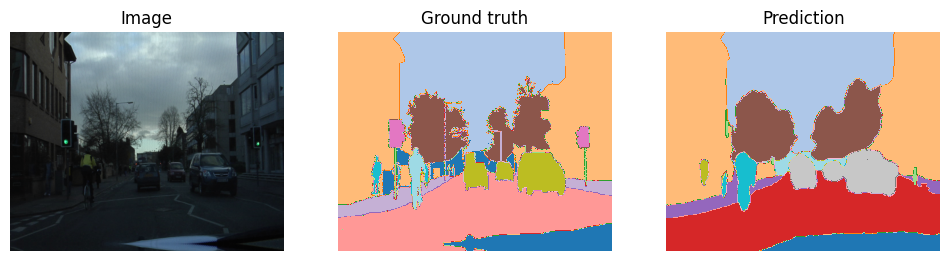

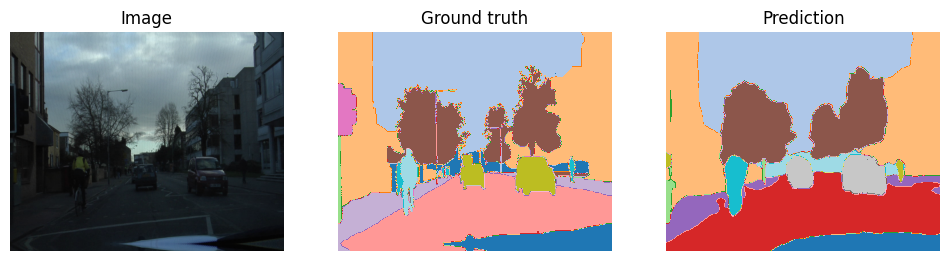

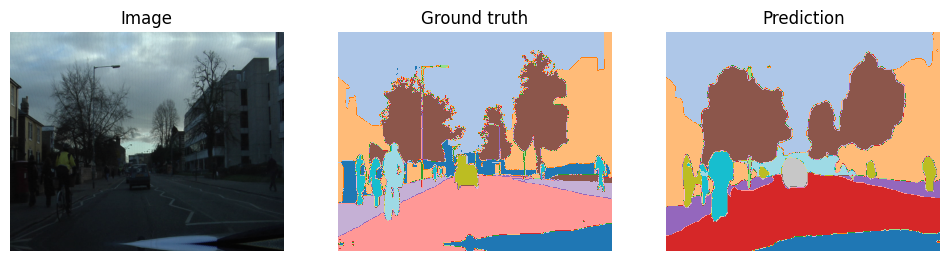

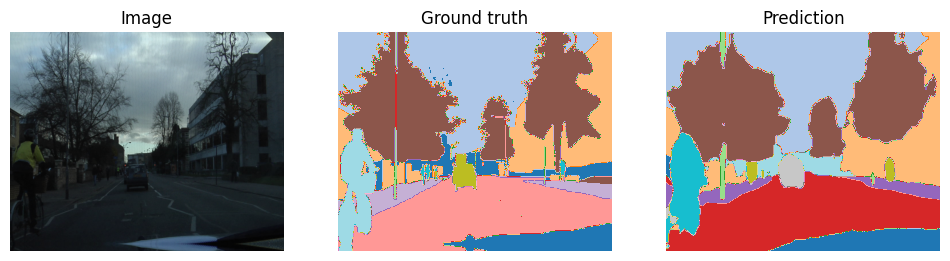

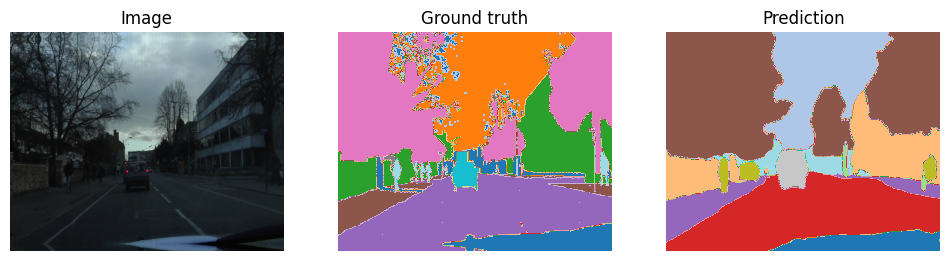

In [ ]:
import numpy as np

# Fetch a batch from the test loader
images, masks = next(iter(test_loader))

# Switch the model to evaluation mode
with torch.inference_mode():
    model.eval()
    logits = model(images)  # Get raw logits from the model

# Apply softmax to get class probabilities
# Shape: [batch_size, num_classes, H, W]

pr_masks = logits.softmax(dim=1)
# Convert class probabilities to predicted class labels
pr_masks = pr_masks.argmax(dim=1)  # Shape: [batch_size, H, W]

# Visualize a few samples (image, ground truth mask, and predicted mask)
for idx, (image, gt_mask, pr_mask) in enumerate(zip(images, masks, pr_masks)):
    if idx <= 4:  # Visualize first 5 samples
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(
            image.cpu().numpy().transpose(1, 2, 0)
        )  # Convert CHW to HWC for plotting
        plt.title("Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.cpu().numpy(), cmap="tab20")  # Visualize ground truth mask
        plt.title("Ground truth")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.cpu().numpy(), cmap="tab20")  # Visualize predicted mask
        plt.title("Prediction")
        plt.axis("off")

        # Show the figure
        plt.show()
    else:
        break